In [21]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
import tarfile
import json 
import hashlib
import re
import itertools

In [22]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

# 15 MB
data_set_zip = "tasks_1-20_v1-2.tar.gz"

#Select "task 5"
train_set_file = "qa5_three-arg-relations_train.txt"
test_set_file = "qa5_three-arg-relations_test.txt"

train_set_post_file = "tasks_1-20_v1-2/en/"+train_set_file
test_set_post_file = "tasks_1-20_v1-2/en/"+test_set_file

In [23]:
try: from urllib.request import urlretrieve, urlopen
except ImportError: 
    from urllib import urlretrieve
    from urllib2 import urlopen
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)
if (not os.path.isfile(data_set_zip) and
    not (os.path.isfile(train_set_file) and os.path.isfile(test_set_file))):
    urlretrieve ("https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz", 
                 data_set_zip)

In [24]:
def unzip_single_file(zip_file_name, output_file_name):
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return
def targz_unzip_single_file(zip_file_name, output_file_name, interior_relative_path):
    if not os.path.isfile(output_file_name):
        with tarfile.open(zip_file_name) as un_zipped:
            un_zipped.extract(interior_relative_path+output_file_name)    
unzip_single_file(glove_zip_file, glove_vectors_file)
targz_unzip_single_file(data_set_zip, train_set_file, "tasks_1-20_v1-2/en/")
targz_unzip_single_file(data_set_zip, test_set_file, "tasks_1-20_v1-2/en/")

In [25]:
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [26]:
wvecs = []
for item in glove_wordmap.items():
    wvecs.append(item[1])
s = np.vstack(wvecs)

v = np.var(s,0) 
m = np.mean(s,0) 
RS = np.random.RandomState()

def fill_unk(unk):
    global glove_wordmap
    glove_wordmap[unk] = RS.multivariate_normal(m,np.diag(v))
    return glove_wordmap[unk]

In [27]:
def sentence2sequence(sentence):
    tokens = sentence.strip('"(),-').lower().split(" ")
    rows = []
    words = []
    for token in tokens:
        i = len(token)
        while len(token) > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
                continue
            else:
                i = i-1
            if i == 0:
                rows.append(fill_unk(token))
                words.append(token)
                break
    return np.array(rows), words

In [28]:
def contextualize(set_file):
    data = []
    context = []
    with open(set_file, "r", encoding="utf8") as train:
        for line in train:
            l, ine = tuple(line.split(" ", 1))
            if l is "1":
                context = []
            if "\t" in ine: 
                question, answer, support = tuple(ine.split("\t"))
                data.append((tuple(zip(*context))+
                             sentence2sequence(question)+
                             sentence2sequence(answer)+
                             ([int(s) for s in support.split()],)))
            else:
                context.append(sentence2sequence(ine[:-1]))
    return data
train_data = contextualize(train_set_post_file)
test_data = contextualize(test_set_post_file)

In [29]:
final_train_data = []
def finalize(data):
    final_data = []
    for cqas in train_data:
        contextvs, contextws, qvs, qws, avs, aws, spt = cqas

        lengths = itertools.accumulate(len(cvec) for cvec in contextvs)
        context_vec = np.concatenate(contextvs)
        context_words = sum(contextws,[])

        sentence_ends = np.array(list(lengths)) 
        final_data.append((context_vec, sentence_ends, qvs, spt, context_words, cqas, avs, aws))
    return np.array(final_data)
final_train_data = finalize(train_data)   
final_test_data = finalize(test_data)

In [30]:
tf.reset_default_graph()

In [31]:
recurrent_cell_size = 128
D = 50 
learning_rate = 0.005
input_p, output_p = 0.5, 0.5
batch_size = 128
passes = 4
ff_hidden_size = 256
weight_decay = 0.00000001
training_iterations_count = 400000
display_step = 100

In [32]:
context = tf.placeholder(tf.float32, [None, None, D], "context")  
context_placeholder = context

input_sentence_endings = tf.placeholder(tf.int32, [None, None, 2], "sentence")

input_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

gru_drop = tf.contrib.rnn.DropoutWrapper(input_gru, input_p, output_p)

input_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, context, dtype=tf.float32, scope = "input_module")

cs = tf.gather_nd(input_module_outputs, input_sentence_endings)
s = input_module_outputs

In [33]:
query = tf.placeholder(tf.float32, [None, None, D], "query")
input_query_lengths = tf.placeholder(tf.int32, [None, 2], "query_lengths")

question_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, query, dtype=tf.float32, 
                                               scope = tf.VariableScope(True, "input_module"))

q = tf.gather_nd(question_module_outputs, input_query_lengths)

In [34]:
size = tf.stack([tf.constant(1),tf.shape(cs)[1], tf.constant(1)])
re_q = tf.tile(tf.reshape(q,[-1,1,recurrent_cell_size]),size)


output_size = 1 

attend_init = tf.random_normal_initializer(stddev=0.1)
w_1 = tf.get_variable("attend_w1", [1,recurrent_cell_size*7, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
w_2 = tf.get_variable("attend_w2", [1,recurrent_cell_size, output_size], 
                      tf.float32, initializer = attend_init)

b_1 = tf.get_variable("attend_b1", [1, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
b_2 = tf.get_variable("attend_b2", [1, output_size], 
                      tf.float32, initializer = attend_init)

tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_2))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_2))

def attention(c, mem, existing_facts):
    with tf.variable_scope("attending") as scope:
        attending = tf.concat([c, mem, re_q, c * re_q,  c * mem, (c-re_q)**2, (c-mem)**2], 2)

        m1 = tf.matmul(attending * existing_facts, 
                       tf.tile(w_1, tf.stack([tf.shape(attending)[0],1,1]))) * existing_facts
        
        bias_1 = b_1 * existing_facts

        tnhan = tf.nn.relu(m1 + bias_1)

        m2 = tf.matmul(tnhan, tf.tile(w_2, tf.stack([tf.shape(attending)[0],1,1])))

        bias_2 = b_2 * existing_facts

        norm_m2 = tf.nn.l2_normalize(m2 + bias_2, -1)

        softmax_idx = tf.where(tf.not_equal(norm_m2, 0))[:,:-1]
        softmax_gather = tf.gather_nd(norm_m2[...,0], softmax_idx)
        softmax_shape = tf.shape(norm_m2, out_type=tf.int64)[:-1]
        softmaxable = tf.SparseTensor(softmax_idx, softmax_gather, softmax_shape)
        return tf.expand_dims(tf.sparse_tensor_to_dense(tf.sparse_softmax(softmaxable)),-1)

facts_0s = tf.cast(tf.count_nonzero(input_sentence_endings[:,:,-1:],-1,keep_dims=True),tf.float32)


with tf.variable_scope("Episodes") as scope:
    attention_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

    memory = [q]

    attends = []
    for a in range(passes):
        attend_to = attention(cs, tf.tile(tf.reshape(memory[-1],[-1,1,recurrent_cell_size]),size),
                              facts_0s)

        retain = 1-attend_to

        while_valid_index = (lambda state, index: index < tf.shape(cs)[1])
        update_state = (lambda state, index: (attend_to[:,index,:] * 
                                                 attention_gru(cs[:,index,:], state)[0] + 
                                                 retain[:,index,:] * state))
        memory.append(tuple(tf.while_loop(while_valid_index,
                          (lambda state, index: (update_state(state,index),index+1)),
                           loop_vars = [memory[-1], 0]))[0]) 

        attends.append(attend_to)

        scope.reuse_variables()

In [35]:
a0 = tf.concat([memory[-1], q], -1)

fc_init = tf.random_normal_initializer(stddev=0.1) 

with tf.variable_scope("answer"):
    w_answer = tf.get_variable("weight", [recurrent_cell_size*2, D], 
                               tf.float32, initializer = fc_init)
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(w_answer)) 

    logit = tf.expand_dims(tf.matmul(a0, w_answer),1)

    with tf.variable_scope("ending"):
        all_ends = tf.reshape(input_sentence_endings, [-1,2])
        range_ends = tf.range(tf.shape(all_ends)[0])
        ends_indices = tf.stack([all_ends[:,0],range_ends], axis=1)
        ind = tf.reduce_max(tf.scatter_nd(ends_indices, all_ends[:,1],
                                          [tf.shape(q)[0], tf.shape(all_ends)[0]]),
                            axis=-1)
        range_ind = tf.range(tf.shape(ind)[0])
        mask_ends = tf.cast(tf.scatter_nd(tf.stack([ind, range_ind], axis=1), 
                                          tf.ones_like(range_ind), [tf.reduce_max(ind)+1, 
                                                                    tf.shape(ind)[0]]), bool)
        mask = tf.scan(tf.logical_xor,mask_ends, tf.ones_like(range_ind, dtype=bool))

    logits = -tf.reduce_sum(tf.square(context*tf.transpose(tf.expand_dims(
                    tf.cast(mask, tf.float32),-1),[1,0,2]) - logit), axis=-1)

In [36]:
gold_standard = tf.placeholder(tf.float32, [None, 1, D], "answer")
with tf.variable_scope('accuracy'):
    eq = tf.equal(context, gold_standard)
    corrbool = tf.reduce_all(eq,-1)
    logloc = tf.reduce_max(logits, -1, keep_dims = True)
    locs = tf.equal(logits, logloc)

    correctsbool = tf.reduce_any(tf.logical_and(locs, corrbool), -1)
    corrects = tf.where(correctsbool, tf.ones_like(correctsbool, dtype=tf.float32), 
                        tf.zeros_like(correctsbool,dtype=tf.float32))

    corr = tf.where(corrbool, tf.ones_like(corrbool, dtype=tf.float32), 
                        tf.zeros_like(corrbool,dtype=tf.float32))
with tf.variable_scope("loss"):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.nn.l2_normalize(logits,-1),
                                                   labels = corr)

    total_loss = tf.reduce_mean(loss) + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.AdamOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

In [37]:

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [38]:
def prep_batch(batch_data, more_data = False):
    context_vec, sentence_ends, questionvs, spt, context_words, cqas, answervs, _ = zip(*batch_data)
    ends = list(sentence_ends)
    maxend = max(map(len, ends))
    aends = np.zeros((len(ends), maxend))
    for index, i in enumerate(ends):
        for indexj, x in enumerate(i):
            aends[index, indexj] = x-1
    new_ends = np.zeros(aends.shape+(2,))

    for index, x in np.ndenumerate(aends):
        new_ends[index+(0,)] = index[0]
        new_ends[index+(1,)] = x

    contexts = list(context_vec)
    max_context_length = max([len(x) for x in contexts])
    contextsize = list(np.array(contexts[0]).shape)
    contextsize[0] = max_context_length
    final_contexts = np.zeros([len(contexts)]+contextsize)

    contexts = [np.array(x) for x in contexts]
    for i, context in enumerate(contexts):
        final_contexts[i,0:len(context),:] = context
    max_query_length = max(len(x) for x in questionvs)
    querysize = list(np.array(questionvs[0]).shape)
    querysize[:1] = [len(questionvs),max_query_length]
    queries = np.zeros(querysize)
    querylengths = np.array(list(zip(range(len(questionvs)),[len(q)-1 for q in questionvs])))
    questions = [np.array(q) for q in questionvs]
    for i, question in enumerate(questions):
        queries[i,0:len(question),:] = question
    data = {context_placeholder: final_contexts, input_sentence_endings: new_ends, 
                            query:queries, input_query_lengths:querylengths, gold_standard: answervs}
    return (data, context_words, cqas) if more_data else data

In [39]:
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass


batch = np.random.randint(final_test_data.shape[0], size=batch_size*10)
batch_data = final_test_data[batch]

validation_set, val_context_words, val_cqas = prep_batch(batch_data, True)

def train(iterations, batch_size):
    training_iterations = range(0,iterations,batch_size)
    if tqdm_installed:
        training_iterations = tqdm(training_iterations)

    wordz = []
    for j in training_iterations:

        batch = np.random.randint(final_train_data.shape[0], size=batch_size)
        batch_data = final_train_data[batch]

        sess.run([opt_op], feed_dict=prep_batch(batch_data))
        if (j/batch_size) % display_step == 0:

            acc, ccs, tmp_loss, log, con, cor, loc  = sess.run([corrects, cs, total_loss, logit,
                                                                context_placeholder,corr, locs], 
                                                               feed_dict=validation_set)
            print("Iter " + str(j/batch_size) + ", Minibatch Loss= ",tmp_loss,
                  "Accuracy= ", np.mean(acc))
train(400000,batch_size)

  0%|          | 1/3125 [00:48<42:24:33, 48.87s/it]

Iter 0.0, Minibatch Loss=  0.6728524 Accuracy=  0.0953125


  3%|▎         | 101/3125 [14:12<7:05:28,  8.44s/it]

Iter 100.0, Minibatch Loss=  0.6727554 Accuracy=  0.3671875


  6%|▋         | 201/3125 [26:38<6:27:28,  7.95s/it]

Iter 200.0, Minibatch Loss=  0.672751 Accuracy=  0.42421874


 10%|▉         | 301/3125 [38:13<5:58:37,  7.62s/it]

Iter 300.0, Minibatch Loss=  0.6727286 Accuracy=  0.4875


 13%|█▎        | 401/3125 [48:52<5:31:58,  7.31s/it]

Iter 400.0, Minibatch Loss=  0.6727315 Accuracy=  0.5625


 16%|█▌        | 501/3125 [59:43<5:12:49,  7.15s/it]

Iter 500.0, Minibatch Loss=  0.6727182 Accuracy=  0.6148437


 19%|█▉        | 601/3125 [1:10:32<4:56:14,  7.04s/it]

Iter 600.0, Minibatch Loss=  0.6727019 Accuracy=  0.6984375


 22%|██▏       | 701/3125 [1:20:23<4:38:00,  6.88s/it]

Iter 700.0, Minibatch Loss=  0.67271155 Accuracy=  0.73125


 26%|██▌       | 801/3125 [1:31:27<4:25:21,  6.85s/it]

Iter 800.0, Minibatch Loss=  0.67268497 Accuracy=  0.76875


 29%|██▉       | 901/3125 [1:42:31<4:13:03,  6.83s/it]

Iter 900.0, Minibatch Loss=  0.6726597 Accuracy=  0.7835938


 32%|███▏      | 1001/3125 [1:54:13<4:02:21,  6.85s/it]

Iter 1000.0, Minibatch Loss=  0.6726565 Accuracy=  0.80078125


 35%|███▌      | 1101/3125 [12:37:25<23:12:24, 41.28s/it]

Iter 1100.0, Minibatch Loss=  0.67262393 Accuracy=  0.821875


 38%|███▊      | 1201/3125 [12:48:31<20:31:10, 38.39s/it]

Iter 1200.0, Minibatch Loss=  0.6726484 Accuracy=  0.83671874


 42%|████▏     | 1301/3125 [12:57:49<18:10:31, 35.87s/it]

Iter 1300.0, Minibatch Loss=  0.67264616 Accuracy=  0.8648437


 45%|████▍     | 1401/3125 [13:07:20<16:08:51, 33.72s/it]

Iter 1400.0, Minibatch Loss=  0.67261076 Accuracy=  0.87421876


 48%|████▊     | 1501/3125 [13:17:06<14:22:26, 31.86s/it]

Iter 1500.0, Minibatch Loss=  0.6725826 Accuracy=  0.8851563


 51%|█████     | 1601/3125 [13:27:03<12:48:14, 30.25s/it]

Iter 1600.0, Minibatch Loss=  0.672601 Accuracy=  0.9078125


 54%|█████▍    | 1701/3125 [13:36:43<11:23:43, 28.81s/it]

Iter 1700.0, Minibatch Loss=  0.67260927 Accuracy=  0.88125


 58%|█████▊    | 1801/3125 [13:48:59<10:09:25, 27.62s/it]

Iter 1800.0, Minibatch Loss=  0.6726035 Accuracy=  0.89375


 61%|██████    | 1901/3125 [14:01:03<9:01:31, 26.55s/it]

Iter 1900.0, Minibatch Loss=  0.6725866 Accuracy=  0.90546876


 64%|██████▍   | 2001/3125 [14:12:41<7:58:58, 25.57s/it]

Iter 2000.0, Minibatch Loss=  0.6725823 Accuracy=  0.9171875


 67%|██████▋   | 2101/3125 [14:23:11<7:00:42, 24.65s/it]

Iter 2100.0, Minibatch Loss=  0.67259485 Accuracy=  0.90625


 70%|███████   | 2201/3125 [14:33:45<6:06:48, 23.82s/it]

Iter 2200.0, Minibatch Loss=  0.67260253 Accuracy=  0.93046874


 74%|███████▎  | 2301/3125 [14:43:33<5:16:24, 23.04s/it]

Iter 2300.0, Minibatch Loss=  0.67259663 Accuracy=  0.9195312


 77%|███████▋  | 2401/3125 [14:53:15<4:29:21, 22.32s/it]

Iter 2400.0, Minibatch Loss=  0.6725898 Accuracy=  0.92890626


 80%|████████  | 2501/3125 [15:02:40<3:45:13, 21.66s/it]

Iter 2500.0, Minibatch Loss=  0.6725982 Accuracy=  0.9164063


 83%|████████▎ | 2601/3125 [15:12:32<3:03:50, 21.05s/it]

Iter 2600.0, Minibatch Loss=  0.67258346 Accuracy=  0.9164063


 86%|████████▋ | 2701/3125 [16:30:53<2:35:32, 22.01s/it]

Iter 2700.0, Minibatch Loss=  0.6725888 Accuracy=  0.9375


 90%|████████▉ | 2801/3125 [16:42:27<1:55:57, 21.47s/it]

Iter 2800.0, Minibatch Loss=  0.6725905 Accuracy=  0.94453126


 93%|█████████▎| 2901/3125 [16:53:21<1:18:14, 20.96s/it]

Iter 2900.0, Minibatch Loss=  0.672588 Accuracy=  0.909375


 96%|█████████▌| 3001/3125 [17:04:22<42:19, 20.48s/it]

Iter 3000.0, Minibatch Loss=  0.6725935 Accuracy=  0.93046874


 99%|█████████▉| 3101/3125 [17:14:41<08:00, 20.02s/it]

Iter 3100.0, Minibatch Loss=  0.67259914 Accuracy=  0.9203125


100%|██████████| 3125/3125 [17:16:58<00:00, 19.91s/it]


In [40]:
print(np.mean(sess.run([corrects], feed_dict= prep_batch(final_test_data))[0]))

0.955


In [40]:
true_val = []
predicted_val = []

indices = np.argmax(n,axis=1)


indicesc = np.argmax(a,axis=1)

for i,e,cw, cqa in list(zip(indices, indicesc, val_context_words, val_cqas)):
    if cw[i] != 'picked':
        true_val.append(cw[i])
        predicted_val.append(cw[e])
    

In [41]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

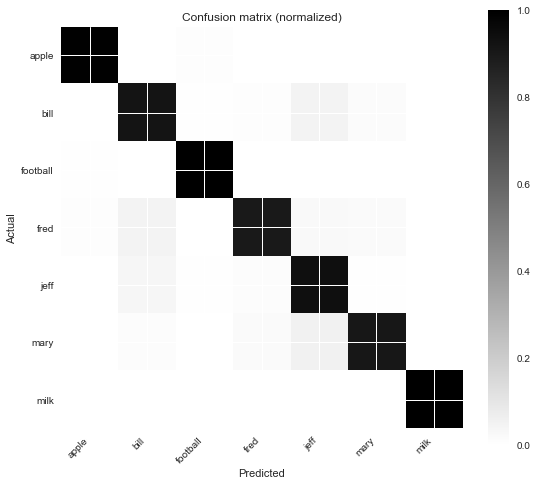

In [42]:
cm = ConfusionMatrix(predicted_val,true_val)
cm.plot(normalized=True)
plt.show()